# Prevendo dados da Bolsa de Valores

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

## 1.0 - Informações sobre a BVSP

In [2]:
ticker = "^BVSP"

ibovespa = yf.Ticker(ticker)
ibovespa.info

{'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 128523.83,
 'open': 128524.43,
 'dayLow': 127691.19,
 'dayHigh': 129046.63,
 'regularMarketPreviousClose': 128523.83,
 'regularMarketOpen': 128524.43,
 'regularMarketDayLow': 127691.19,
 'regularMarketDayHigh': 129046.63,
 'averageVolume': 10873805,
 'averageVolume10days': 9294940,
 'averageDailyVolume10Day': 9294940,
 'fiftyTwoWeekLow': 96997.0,
 'fiftyTwoWeekHigh': 134392.0,
 'fiftyDayAverage': 127658.56,
 'twoHundredDayAverage': 117295.984,
 'currency': 'BRL',
 'exchange': 'SAO',
 'quoteType': 'INDEX',
 'symbol': '^BVSP',
 'underlyingSymbol': '^BVSP',
 'shortName': 'IBOVESPA',
 'longName': 'IBOVESPA',
 'firstTradeDateEpochUtc': 735915600,
 'timeZoneFullName': 'America/Sao_Paulo',
 'timeZoneShortName': 'BRT',
 'uuid': 'd9d25d96-d9ea-3b77-bca7-9e274228b02e',
 'messageBoardId': 'finmb_INDEXBVSP',
 'gmtOffSetMilliseconds': -10800000,
 'trailingPegRatio': None}

### 1.1 - Dados da BVSP nos últimos 3 anos

In [3]:
df = ibovespa.history(period="3y")
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,748.000000,748.000000,748.000000,748.000000,7.480000e+02,748.0,748.0
mean,113738.555387,114714.436675,112761.905331,113746.219836,1.145017e+07,0.0,0.0
std,7962.772807,7865.285167,8024.173353,7975.869696,3.537875e+06,0.0,0.0
min,96119.000000,96971.000000,95267.000000,96121.000000,0.000000e+00,0.0,0.0
25%,108238.000000,109145.250000,107298.500000,108207.500000,9.403700e+06,0.0,0.0
50%,113293.000000,114336.500000,112163.500000,113330.000000,1.136010e+07,0.0,0.0
75%,118881.250000,119680.000000,117982.000000,118887.250000,1.329652e+07,0.0,0.0
max,134194.000000,134392.000000,133832.000000,134194.000000,2.602930e+07,0.0,0.0


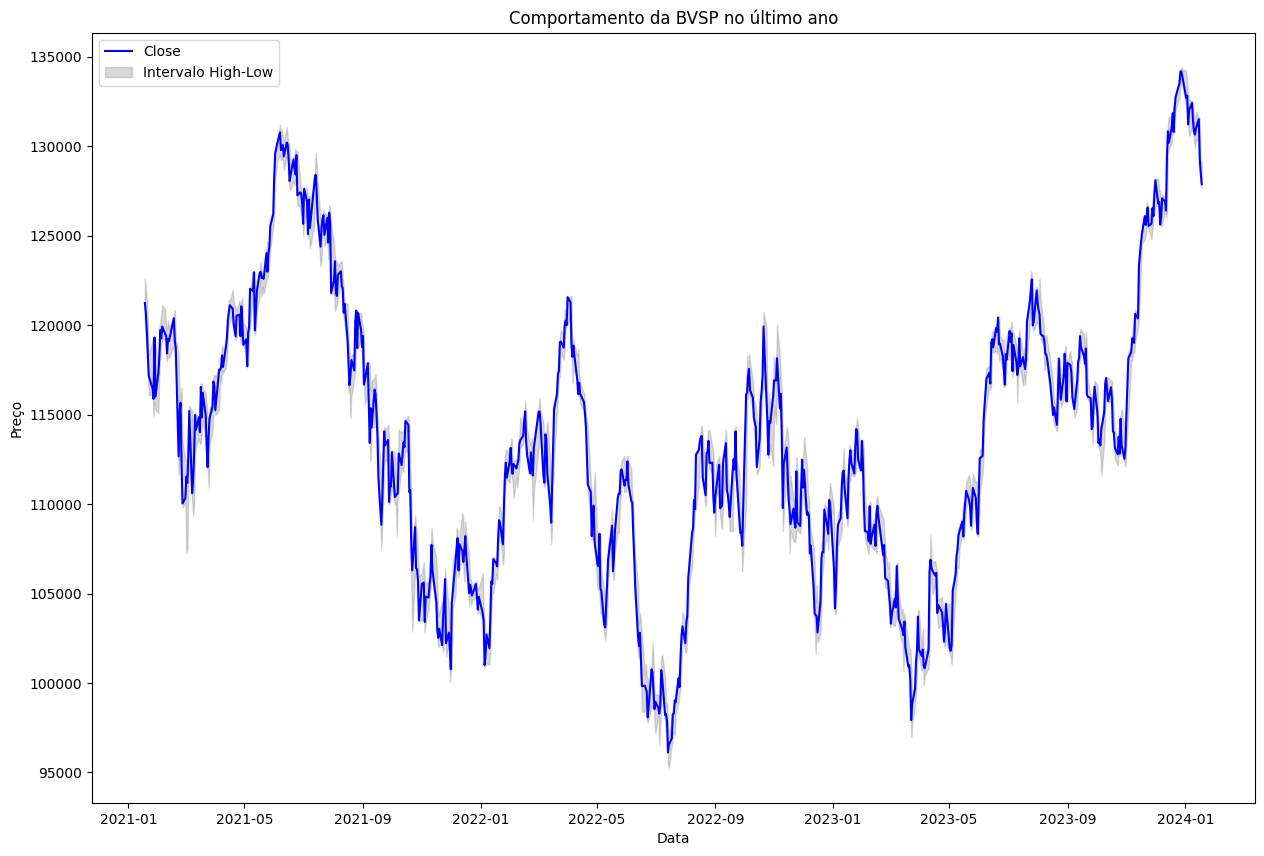

In [4]:
plt.figure(figsize=(15, 10))
plt.plot(df.index, df["Close"], label="Close", color="blue")
plt.fill_between(df.index, df["Low"], df["High"], color="gray", alpha=0.3, label="Intervalo High-Low")
plt.legend()

plt.title("Comportamento da BVSP no último ano")
plt.xlabel("Data")
plt.ylabel("Preço")

plt.show()

### 1.2 - Decomposição dos dados da BVSP

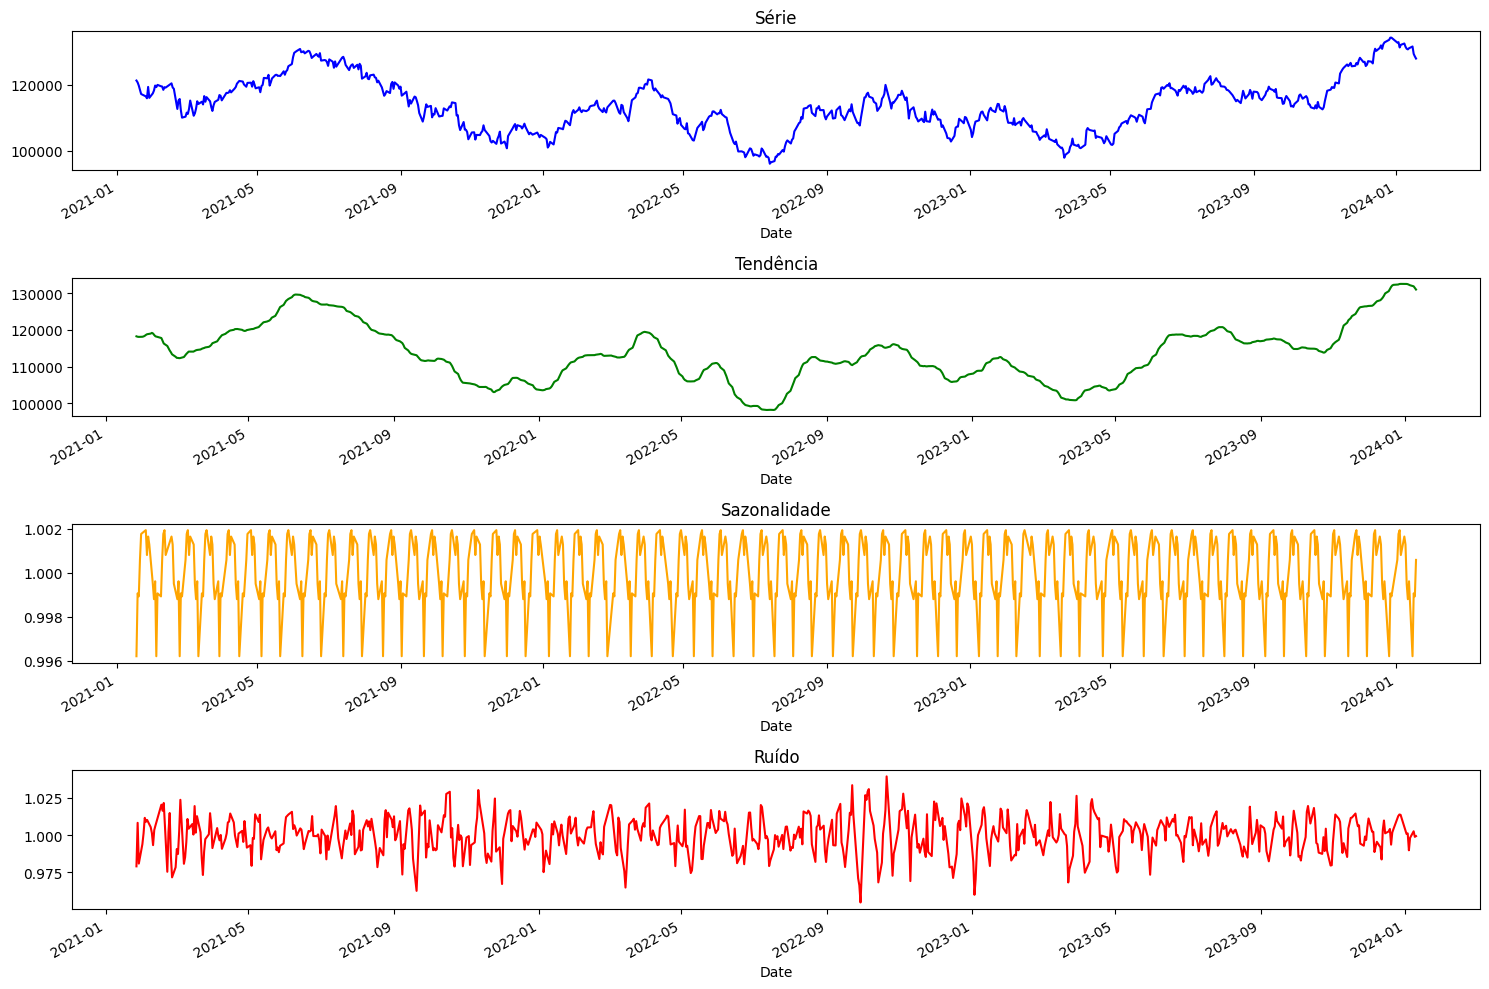

In [5]:
df_decomposed = df.copy()
df_decomposed = df.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"])

seasonplot = seasonal_decompose(df_decomposed, model='multiplicative', period=12)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,10))
seasonplot.observed.plot(ax=ax1, title="Série", color="blue")
seasonplot.trend.plot(ax=ax2, title="Tendência", color="green")
seasonplot.seasonal.plot(ax=ax3, title="Sazonalidade", color="orange")
seasonplot.resid.plot(ax=ax4, title="Ruído", color="red")
plt.tight_layout()

## 2.0 Prevendo dados da BVSP

### 2.1 Modelo ARIMA

Para aplicar o modelo ARIMA (Autoregressive Integrated Moving Average) é preciso entender a autocorrelação e a autocorrelação parcial.

#### 2.1.1 - Medindo a autocorrelação

Valores próximos a 1 e -1 indicam uma forte correlação positiva ou negativa (proporcionalidade inversa). Como é possível observar, no início do gráfico a autocorrelação é bastante alta, significando que os eventos passados tem correlação positiva com eventos futuros, porém, essa relação vai se degradando conforme o passar do tempo. Isso significa que os eventos muito no passado têm pouco impacto sobre eventos no presente (comportamento típico de uma série temporal).

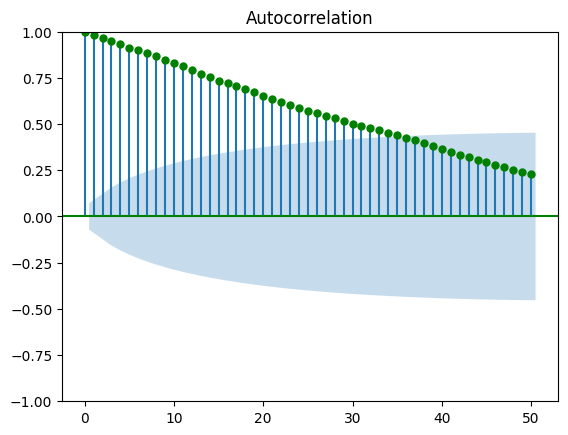

In [6]:
sm.graphics.tsa.plot_acf(df_decomposed, lags=50, color="green")
plt.show()

#### 2.1.2 - Medindo a autocorrelação parcial

A autocorrelação parcial mede o quanto os valores posteriores são relacionados com os valores iniciais. No gráfico abaixo, é possível ver que o evento mais próximo do primeiro valor é altamente correlacionado com o mesmo. Podemos chegar na conclusão de que o nível de AR (autoregressão) do modelo ARIMA ideal é de 1.

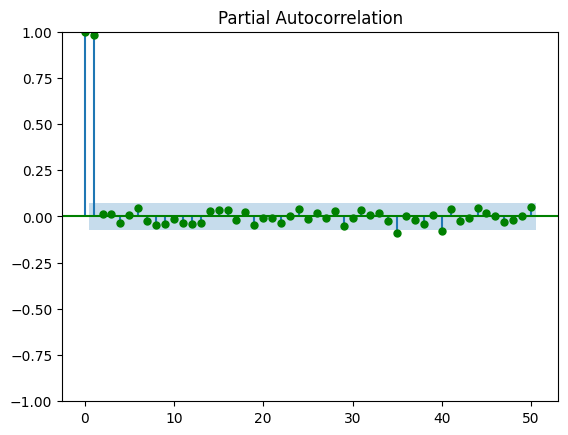

In [7]:
sm.graphics.tsa.plot_pacf(df_decomposed, lags=50, color="green")
plt.show()

#### 2.1.3 - Testando a estacionariedade da série com ADF (Augmented Dick-Fuller)

Para aplicar o modelo ARIMA, é importante integrarmos nossa série até que ela seja estacionária (baixo desvio padrão). O teste ADF nos diz o quanto uma série é ou não estacionária nos informando a H0 (Hipótese Nula) que diz que uma série não é estacionária ou nos informando HA (Hipótese Alternativa) que diz que a série é estacionária. Para considerar uma hipótese HA, o valor de P precisa estar mais próximo de 1 e os Valores Críticos precisam estar próximos do valor do teste ADF. No caso abaixo, é possível observar que, apesar do P-Value ser próximo a 1, a série não é estacionária pois os valores críticos diferem muito do teste ADF.

In [8]:
def test_adf(timeseries):
    adf_result = adfuller(timeseries["Close"], autolag="AIC")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"P-Value: {adf_result[1]}")
    print("Teste de Estacionariedade: ")
    print("-" * 38)
    print(f"Teste ADF: {adf_result[0]}")
    print(f"P: {adf_result[1]}")
    print("Valores Críticos:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")

test_adf(df_decomposed)

ADF Statistic: -2.15658563271772
P-Value: 0.2223777895539809
Teste de Estacionariedade: 
--------------------------------------
Teste ADF: -2.15658563271772
P: 0.2223777895539809
Valores Críticos:
	1%: -3.439134355513998
	5%: -2.865416893922985
	10%: -2.56883447171999


#### 2.1.4 - Tornando a série estacionária usando diferenciação

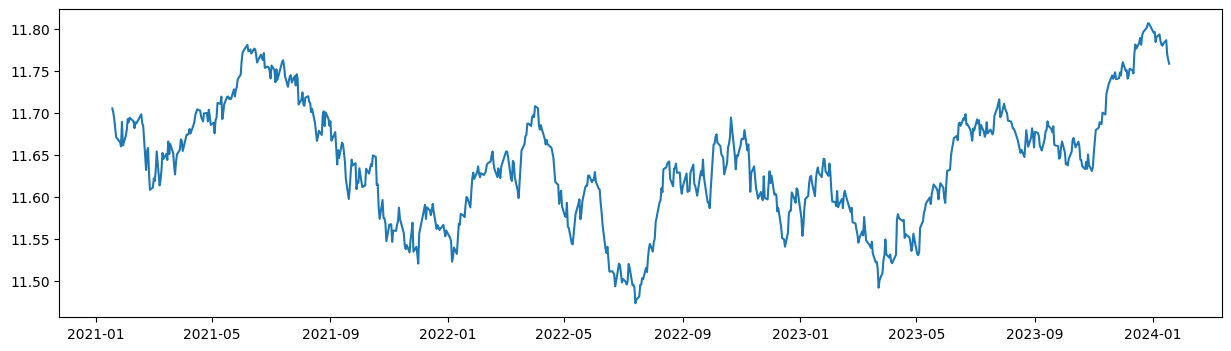

In [9]:
# Mudando a escala do gráfico
plt.figure(figsize=(15, 4))
df_decomposed_log = np.log(df_decomposed)
plt.plot(df_decomposed_log)

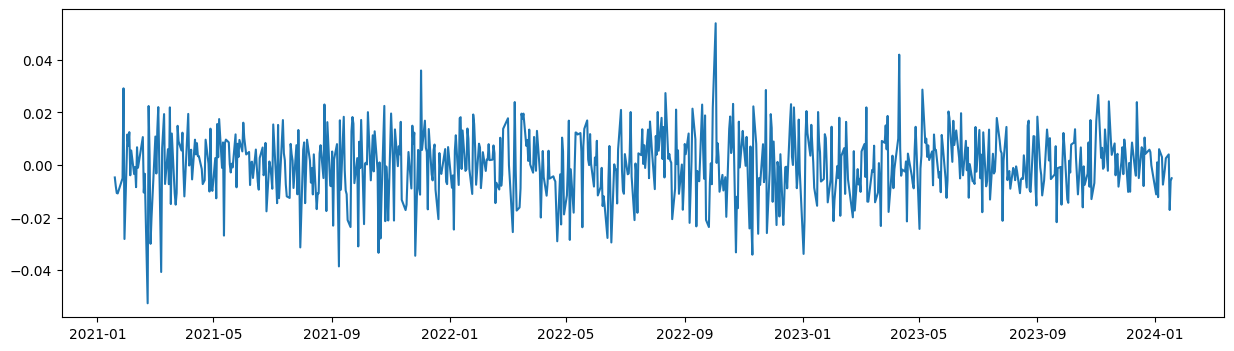

In [10]:
# Subtraindo a diferença entre o valor atual e o anterior
plt.figure(figsize=(15, 4))
df_decomposed_log_shifted = df_decomposed_log - df_decomposed_log.shift()
df_decomposed_log_shifted.dropna(inplace=True)
plt.plot(df_decomposed_log_shifted)

In [11]:
test_adf(df_decomposed_log_shifted)

ADF Statistic: -27.82367885798461
P-Value: 0.0
Teste de Estacionariedade: 
--------------------------------------
Teste ADF: -27.82367885798461
P: 0.0
Valores Críticos:
	1%: -3.439146171679794
	5%: -2.865422101274577
	10%: -2.568837245865348


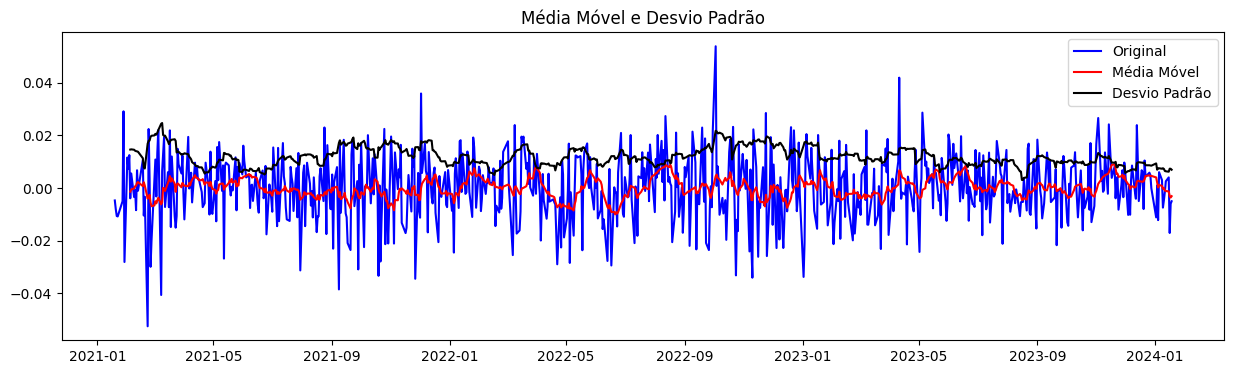

In [12]:
plt.figure(figsize=(15, 4))
moving_average = df_decomposed_log_shifted.rolling(window=12).mean()
moving_std = df_decomposed_log_shifted.rolling(window=12).std()

original = plt.plot(df_decomposed_log_shifted, color="blue", label="Original")
mean = plt.plot(moving_average, color="red", label="Média Móvel")
std = plt.plot(moving_std, color="black", label="Desvio Padrão")
plt.legend(loc="best")
plt.title("Média Móvel e Desvio Padrão")
plt.show(block=False)

#### 2.1.5 - Aplicando o modelo ARIMA

/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWar

Text(0.5, 1.0, 'RSS: 0.1154')

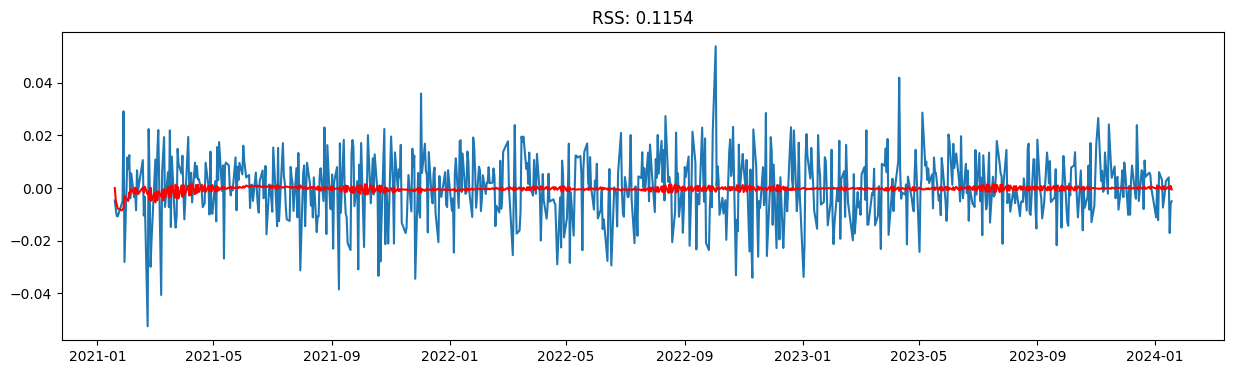

In [13]:
model = ARIMA(df_decomposed_log_shifted, order=(2,1,2))#(p,d,q)
arima_result = model.fit()
plt.figure(figsize=(15, 4))
plt.plot(df_decomposed_log_shifted)
plt.plot(arima_result.fittedvalues, color="red")
plt.title(f"RSS: {sum((arima_result.fittedvalues - df_decomposed_log_shifted['Close'])**2):.4f}")

##### 2.5.1.1 - Medindo a eficácia do ARIMA com MAPE (Mean Absolute Percentage Error)

É possível observar que a taxa de erros é relativamente alta.

In [14]:
predictions = arima_result.fittedvalues

predicted_values = df_decomposed_log_shifted["Close"].iloc[0] + np.cumsum(predictions)

mape = mean_absolute_error(df_decomposed_log_shifted["Close"], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 19.67%


### 2.2 - Usando a biblioteca Prophet

#### 2.2.1 - Medindo a eficácia do Prophet com MAPE (Mean Absolute Percentage Error)

Como é possível observar, a taxa de erros é bem menor do que usando o modelo ARIMA.

In [15]:
df["ds"] = df.index.tz_localize(None)
df["y"] = df["Close"].astype(float)

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

model = Prophet(daily_seasonality=True)
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

y_pred = forecast['yhat'][-len(test_df):]
y_pred = y_pred.reset_index(drop=True)

y_true = test_df['y']
y_true = y_true.reset_index(drop=True)

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAPE: {mape}%")

12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 6.360822204788083%


#### 2.2.2 - Plotando as previsões da biblioteca Prophet

In [16]:
model = Prophet(daily_seasonality=True)
model.fit(df[['ds', 'y']])

future = model.make_future_dataframe(periods=7)  # Prevendo sete dias
forecast = model.predict(future)
forecast.head()

12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-18,119085.231734,111250.990699,117340.935414,119085.231734,119085.231734,-4594.013417,-4594.013417,-4594.013417,-3305.692054,...,-258.137273,-258.137273,-258.137273,-1030.184090,-1030.184090,-1030.184090,0.0,0.0,0.0,114491.218317
1,2021-01-19,119079.450620,111343.155395,118224.422901,119079.450620,119079.450620,-4254.143426,-4254.143426,-4254.143426,-3305.692054,...,-282.286075,-282.286075,-282.286075,-666.165297,-666.165297,-666.165297,0.0,0.0,0.0,114825.307193
2,2021-01-20,119073.669505,112113.337234,118505.256530,119073.669505,119073.669505,-3759.372068,-3759.372068,-3759.372068,-3305.692054,...,-154.247166,-154.247166,-154.247166,-299.432848,-299.432848,-299.432848,0.0,0.0,0.0,115314.297437
3,2021-01-21,119067.888391,112230.715469,118926.552044,119067.888391,119067.888391,-3321.657290,-3321.657290,-3321.657290,-3305.692054,...,-81.769772,-81.769772,-81.769772,65.804536,65.804536,65.804536,0.0,0.0,0.0,115746.231101
4,2021-01-22,119062.107277,113024.808530,119419.683136,119062.107277,119062.107277,-2930.376523,-2930.376523,-2930.376523,-3305.692054,...,-49.982779,-49.982779,-49.982779,425.298310,425.298310,425.298310,0.0,0.0,0.0,116131.730754


/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(0.5, 1.0, 'Previsões com Prophet')

<Figure size 1500x1000 with 0 Axes>

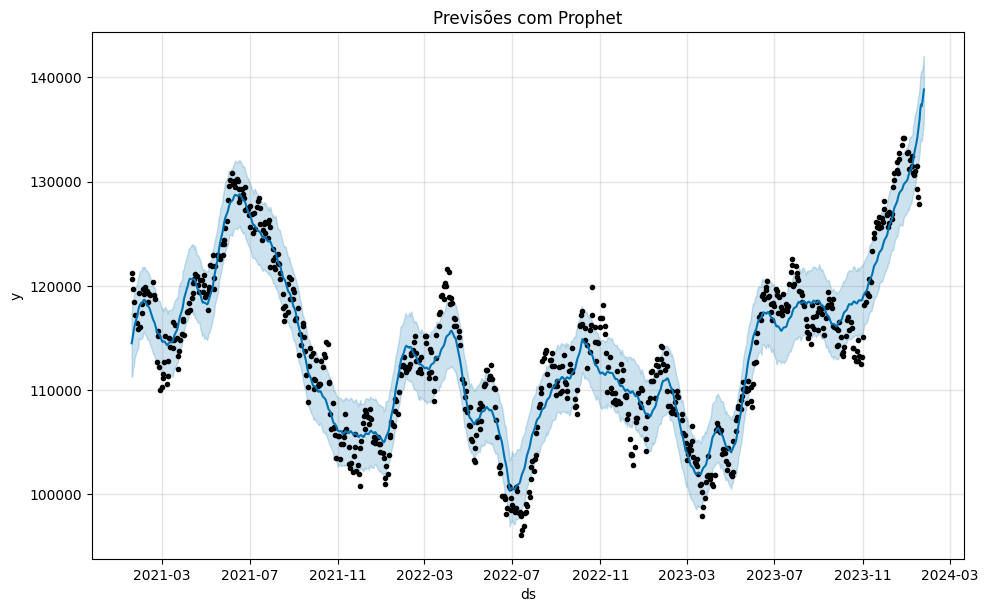

In [17]:
plt.figure(figsize=(15, 10))
fig1 = model.plot(forecast)
plt.title("Previsões com Prophet")